# Task 2

Jerry Wang

## Question 1.1

In [357]:
# Import packages
import pandas as pd
import os
import numpy as np

In [358]:
def combine_phol_table(input_path: str) -> pd.DataFrame:
    """
    Given an input path containing all yearly phol data in .csv format, combine them into a single pandas DataFrame.
    :param input_path: str. Path to the folder containing all yearly phol .csv files.
    :return: pd.DataFrame. Output the combined phol table in pandas DataFrame.
    """
    for root, _, files in os.walk(input_path, topdown=False):
        csv_list = [os.path.join(root, name) for name in files]          
    
    combined_df = pd.concat(map(pd.read_csv, csv_list))

    return combined_df

In [359]:
# Read in the csv and combined them
phol_df = combine_phol_table('./Data/Input/public_holidays')

phol_df.to_csv('./Data/Output/combined_phol.csv', index=False)

# Question 1.2

Before we could create the pivot table, we need to convert the `Date` column to proper format first

In [360]:
phol_df['Date'] = pd.to_datetime(phol_df['Date'].astype(str), format='%Y%m%d')

phol_df['Date']

0     2014-01-01
1     2014-01-27
2     2014-03-03
3     2014-03-10
4     2014-03-10
         ...    
103   2022-06-06
104   2022-09-26
105   2022-12-25
106   2022-12-26
107   2022-12-27
Name: Date, Length: 570, dtype: datetime64[ns]

Checking to see if any PHOL has no state information

In [361]:
phol_df[['Applicable To', 'Jurisdiction']].isnull().all(axis=1).sum()

0

We can see that every PHOL has related state information

After observing the CSV file, we see that for each holiday, there's either `Applicable To` or `Jurisdiction` data, so we can combine both into a single column. We then convert `nat` to list of state names in preparing for next steps.

In [362]:
phol_df['State'] = np.where(phol_df['Applicable To'].isna(), phol_df['Jurisdiction'], phol_df['Applicable To'])

phol_df['State'] = phol_df['State'].str.upper()

phol_df['State'] = phol_df['State'].replace('NAT', 'ACT|NSW|VIC|QLD|WA|NT|SA|TAS')

Here we flag whether the state name is contained in the record.

In [363]:
state_list = ['ACT', 'NSW', 'VIC', 'QLD', 'WA', 'NT', 'SA', 'TAS']

for state in state_list:
    phol_df[state] = phol_df['State'].str.contains(state).astype(int)

Creating the weekday column

In [364]:
phol_df['weekday'] = phol_df['Date'].dt.day_name()

Saving a copy and selecting relevant columns

In [365]:
phol_df_copy = phol_df.copy()

phol_df_copy = phol_df_copy[state_list + ['weekday']]

phol_df_copy

,ACT,NSW,VIC,QLD,WA,NT,SA,TAS,weekday
0,1,1,1,1,1,1,1,1,Wednesday
1,1,1,1,1,1,1,1,1,Monday
2,0,0,0,0,1,0,0,0,Monday
3,0,0,0,0,0,0,1,0,Monday
4,1,0,0,0,0,0,0,0,Monday
...,...,...,...,...,...,...,...,...,...
103,0,0,0,0,1,0,0,0,Monday
104,0,0,0,0,1,0,0,0,Monday
105,0,0,0,0,1,0,0,0,Sunday
106,0,0,0,0,1,0,0,0,Monday


Here we transpose the table in preparation for the pivot table

In [366]:
phol_df_copy = phol_df_copy.melt(id_vars='weekday', var_name='State', value_name='Days')

phol_df_copy

,weekday,State,Days
0,Wednesday,ACT,1
1,Monday,ACT,1
2,Monday,ACT,0
3,Monday,ACT,0
4,Monday,ACT,1
...,...,...,...
4555,Monday,TAS,0
4556,Monday,TAS,0
4557,Sunday,TAS,0
4558,Monday,TAS,0


Creating the pivot table

In [367]:
phol_pivot = pd.pivot_table(phol_df_copy, values='Days', index='State', columns='weekday', aggfunc=np.sum)

phol_pivot

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
State,,,,,,,
ACT,16,62,14,12,5,9,6
NSW,16,48,14,14,5,9,6
NT,18,54,14,6,7,11,6
QLD,17,43,15,10,6,9,6
SA,19,54,16,7,9,11,8
TAS,16,47,4,6,5,15,6
VIC,23,42,14,14,5,18,6
WA,16,54,6,5,5,10,6


Creating the stacked bar chart

Text(0.5, 1.0, 'Number of Public Holidays on Each Weekday Per State')

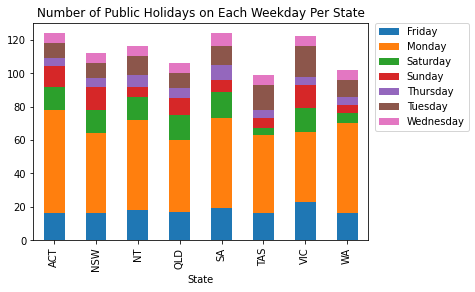

In [368]:
stacked_bar = phol_pivot.plot.bar(stacked=True)

stacked_bar.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

stacked_bar.set_title('Number of Public Holidays on Each Weekday Per State')